## Generate patch data, instance segmentation using watershed method, bounding boxes coordinates generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from PIL import Image

In [2]:
# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 55, 44
r1, r2 = 16, 12
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)

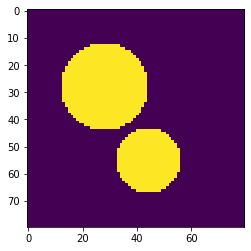

In [3]:
plt.imshow(image);

## Segmentation: watershed approach

In [4]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

In [44]:
from scipy import ndimage
def mask_instance_segmentation(mask):
    """
    Watershed algorithm for mask instance segmentation.
    :mask: 2D ndarray
    """
    distance = ndimage.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
    markers = morphology.label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=mask)
    return labels_ws

In [45]:
labels_ws = mask_instance_segmentation(image)

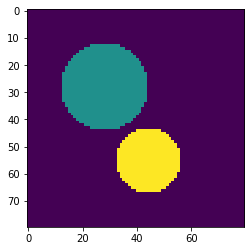

In [46]:
plt.imshow(labels_ws);

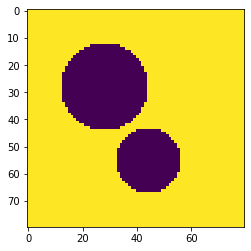

In [47]:
plt.imshow(labels_ws == 0);

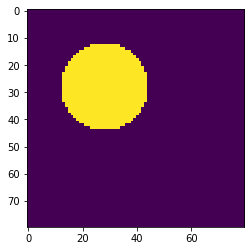

In [48]:
plt.imshow(labels_ws == 1);

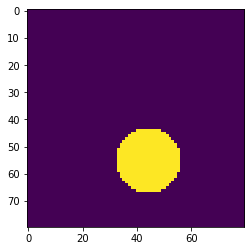

In [49]:
plt.imshow(labels_ws == 2);

In [50]:
np.unique(labels_ws)

array([0, 1, 2], dtype=int32)

So, `0` is the label for the background, `1` - label for the left upper circle, `2` - label for the right down circle.<br>
Now we can build separate binary mask for each circle.

## Build bounding box using segmentation mask

In [9]:
labels_ws == 2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

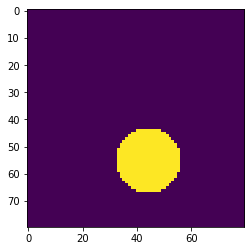

In [11]:
plt.imshow(labels_ws == 2)

In [11]:
np.sum(labels_ws == 2, axis=0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,
       13, 15, 17, 19, 21, 21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 21, 21,
       19, 17, 15, 13,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [12]:
def get_lims_of_positive_elements(arr):
    """
    Computes minimal `i_min` and maximal `i_max` indexses of positive elements.
    :arr: 1D ndarray
    :returns: (i_min, imax)
    """
    i_min, i_max = None, None
    for idx in range(1, len(arr) - 1):
        if arr[idx] > 0:
            if arr[idx - 1] == 0:
                i_min = idx
            if arr[idx + 1] == 0:
                i_max = idx
                break
    # corner cases
    if arr[0] > 0:
        i_min = 0
    if arr[-1] > 0:
        i_max = len(arr) - 1
    return i_min, i_max

In [24]:
a = np.array([0, 0, 1, 2, 3, 0, 0])
# correct answer: (2, 4)
get_lims_of_positive_elements(a)

(2, 4)

In [25]:
b = np.array([1, 1, 0, 0])
# correct answer (0, 1)
get_lims_of_positive_elements(b)

(0, 1)

In [63]:
k = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8]])
k

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [66]:
k.shape

(2, 4)

In [64]:
np.sum(k, axis=1)

array([10, 26])

In [65]:
np.sum(k, axis=0)

array([ 6,  8, 10, 12])

In [87]:
def get_single_bounding_box(mask, label, eps=3):
    """
    Calculates `x_min`, `y_min`, `x_max`, `y_max` coordinates of 2D slice.
    :mask: 2D ndarray with instance segmentation
    :label: int, label of figure for which we are building bounding box
    """
    mask_bin = (mask == label)
    x_min, x_max = get_lims_of_positive_elements(np.sum(mask_bin, axis=1))
    y_min, y_max = get_lims_of_positive_elements(np.sum(mask_bin, axis=0))
    # apply `eps`
    x_min = max(0, x_min - eps)
    x_max = min(mask_bin.shape[0]-1, x_max + eps)
    y_min = max(0, y_min - eps)
    y_max = min(mask_bin.shape[1]-1, y_max + eps)
    return x_min, y_min, x_max, y_max

In [88]:
x_min, y_min, x_max, y_max = get_single_bounding_box(labels_ws, label=2)

In [89]:
x_min, x_max, y_min, y_max

(41, 69, 30, 58)

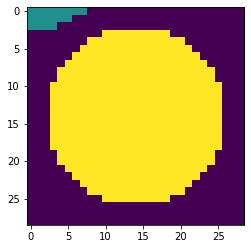

In [90]:
plt.imshow(labels_ws[x_min:(x_max + 1), y_min: (y_max+1)]);

In [91]:
def get_bounding_boxes(seg_labels):
    """
    Returns collection of coordinates of all bounding boxes in the image.
    :seg_labels: 2D ndarray with semantig segmentation labels. `0` - background label,
            other labels - instances we build bounding boxes for.
    """
    res = []
    for label in set(np.unique(seg_labels)) - set([0]):
        res.append(get_single_bounding_box(seg_labels, label))
    return tuple(res)

In [92]:
get_bounding_boxes(labels_ws)

((10, 10, 46, 46), (41, 30, 69, 58))

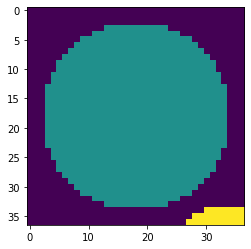

In [93]:
patches = get_bounding_boxes(labels_ws)
# plot first circle with patch
plt.imshow(labels_ws[patches[0][0]:patches[0][2] + 1, patches[0][1]:patches[0][3]+1]);

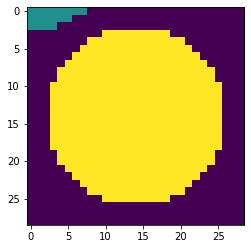

In [94]:
# plot second circle with patch
plt.imshow(labels_ws[patches[1][0]:patches[1][2] + 1, patches[1][1]:patches[1][3]+1]);

## Auxilialry function for bounding boxes display on initial image

In [95]:
import matplotlib.patches as patches
def show_bounding_boxes(mask, image=None):
    """
    Plots `image` with bounding boxes that are built using `mask`.
    :mask: 2D ndarray, semantic segmentation for the `image`. Used to build bounding boxes.
    :image: 2D ndarray, original image. If not provided plots bounding boxes on `mask`.
    """
    if image is None:
        image = mask
    seg_labels = mask_instance_segmentation(mask)
    bboxes = get_bounding_boxes(seg_labels)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    # Create rectangular patch for each bounding box
    for bbox in bboxes:
        patch = patches.Rectangle((bbox[1], bbox[0]), (bbox[3] - bbox[1]), (bbox[2] - bbox[0]),
                                  linewidth=2, edgecolor='r', facecolor='none')
        # add rectangular to the image
        ax.add_patch(patch)
    
    plt.show()

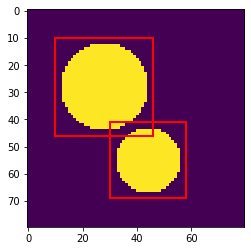

In [96]:
show_bounding_boxes(mask=image)

## Test function on random sparce circles

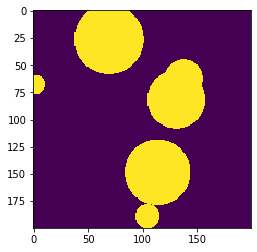

In [117]:
imsize = 200
x, y = np.indices((imsize, imsize))
num_patches = 6
x_origin = np.random.rand(num_patches) * imsize
y_origin = np.random.rand(num_patches) * imsize
r_max = imsize // 5
r = np.random.rand(num_patches) * r_max
# create necessary masks
mask_circles = np.empty((imsize, imsize, num_patches))
for idx in range(mask_circles.shape[2]):
    mask_circles[:, :, idx] = (x - x_origin[idx]) ** 2 + (y - y_origin[idx]) ** 2 < r[idx] ** 2
# create image by iteratively applying logical or
# first initial `logical or` operation
im = np.logical_or(mask_circles[:, :, 0], mask_circles[:, :, 1])
for idx in range(2, num_patches):
    im = np.logical_or(im, mask_circles[:, :, idx])
plt.imshow(im);

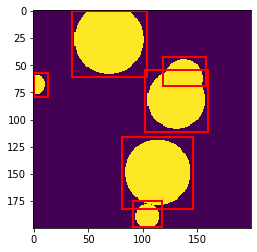

In [118]:
show_bounding_boxes(im)